**Visualize U-Net model run**

In [0]:
from google.colab import drive

In [2]:
drive.mount("/content/gdrive", force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import os
os.chdir('gdrive/My Drive/image-segmentation')

In [0]:
import json

with open('results/unet/all_scalars.json') as json_file:
    data_unet = json.load(json_file)
with open('results/fcdnet/all_scalars.json') as json_file:
    data_fcdnet = json.load(json_file)

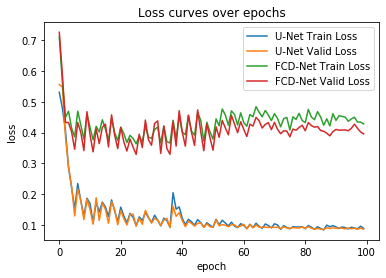

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(data_unet['loss_train'], label='U-Net Train Loss')
plt.plot(data_unet['loss_valid'], label='U-Net Valid Loss')
plt.plot(data_fcdnet['loss_train'], label='FCD-Net Train Loss')
plt.plot(data_fcdnet['loss_valid'], label='FCD-Net Valid Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss curves over epochs')
plt.legend()
plt.show()


In [0]:
import torch
## Load the best model from U-Net and FCD-Net
state_dicts_unet = torch.load('results/unet/model_epoch-86_val_loss-0.0861.pth')
state_dicts_fcdnet = torch.load('results/fcdnet/model_epoch-25_val_loss-0.3294.pth')

In [0]:
from unet.model import UNet
from tiramisu.model import FCDenseNet

In [6]:
unet_model = UNet(in_channels=3, n_classes=1)
unet_model.load_state_dict(state_dicts_unet['model_state_dict'])

fcdnet_model = FCDenseNet(in_channels=3, n_classes=1, n_filter_first_conv=48,
                 n_pool=4, growth_rate=8, n_layers_per_block=3, dropout_p=0.2)
fcdnet_model.load_state_dict(state_dicts_fcdnet['model_state_dict'])

<All keys matched successfully>

In [0]:
import numpy as np
## load training set with images and masks
train_images = np.load('data/train_img_256x256.npy')
train_masks = np.load('data/train_mask_256x256.npy')

In [0]:
np.random.seed(42)
# select 8 indices from training set
random_idx = np.random.randint(low=0, high=len(train_images), size=8)

In [0]:
show_images = train_images[random_idx]
show_masks = train_masks[random_idx]

In [0]:
show_masks = show_masks.astype(float)

In [0]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [0]:
unet_model = unet_model.to(device)
fcdnet_model = fcdnet_model.to(device)

In [0]:
show_images_torch = torch.from_numpy(show_images/255.0)
show_images_torch = show_images_torch.type(torch.FloatTensor)


In [16]:
print(show_images_torch.size())

torch.Size([8, 256, 256, 3])


In [0]:
show_images_torch = show_images_torch.permute(dims=(0, 3, 1, 2))

In [18]:
print(show_images_torch.size())

torch.Size([8, 3, 256, 256])


In [0]:
show_images_torch = show_images_torch.to(device)
predicted_masks_unet = torch.sigmoid(unet_model(show_images_torch)).cpu()
predicted_masks_fcdnet = torch.sigmoid(fcdnet_model(show_images_torch)).cpu()

In [0]:
show_masks_torch = torch.from_numpy(show_masks).permute(dims=(0, 3, 1, 2))

In [0]:
def show(img, title):
    if img.requires_grad:
      img = img.detach()
    npimg = img.numpy()
    img = np.transpose(npimg, (1,2,0))
    if img.shape[2] == 1:
      img = np.squeeze(img)
    plt.imshow(img, interpolation='nearest')
    plt.title(title)
    plt.show()

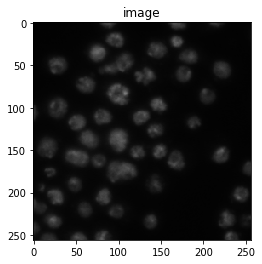

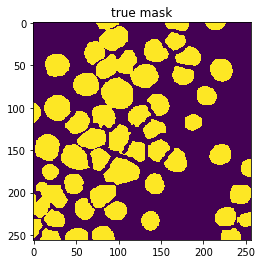

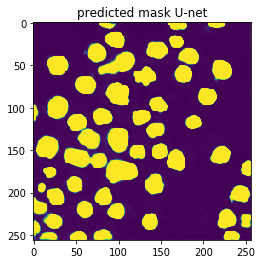

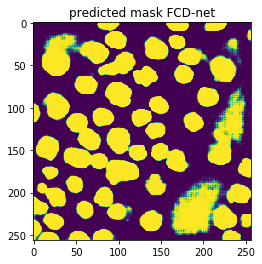

--------------------------------------------------


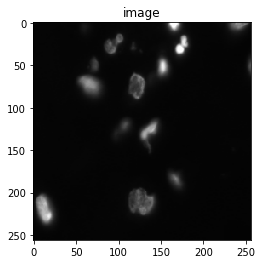

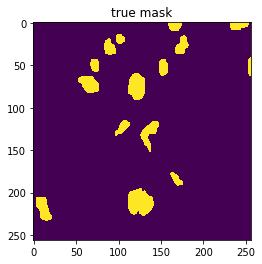

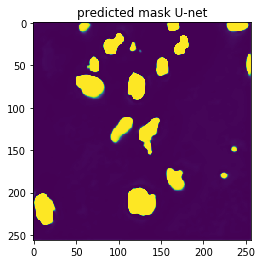

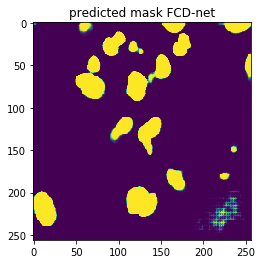

--------------------------------------------------


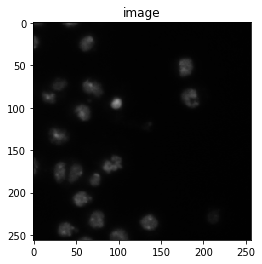

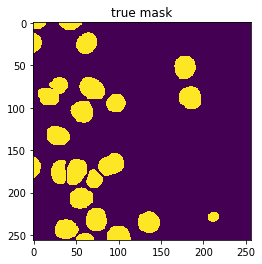

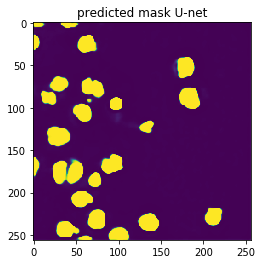

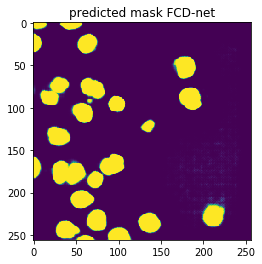

--------------------------------------------------


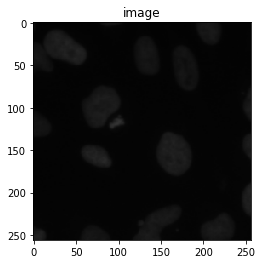

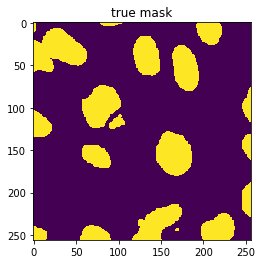

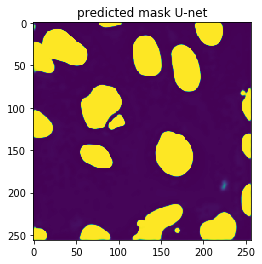

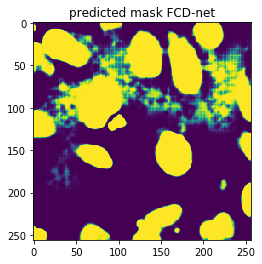

--------------------------------------------------


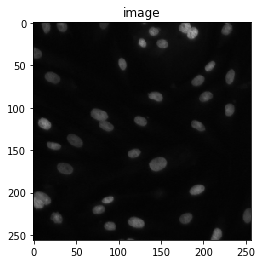

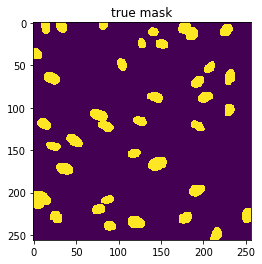

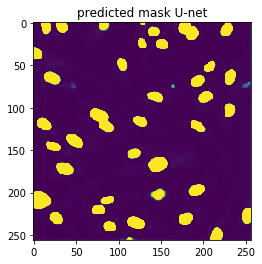

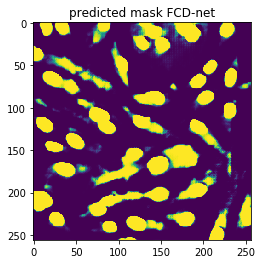

--------------------------------------------------


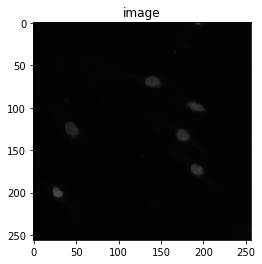

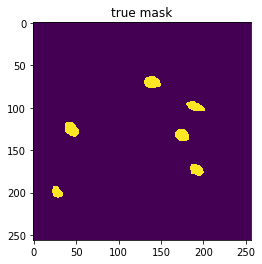

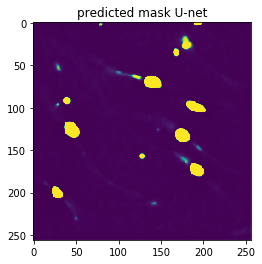

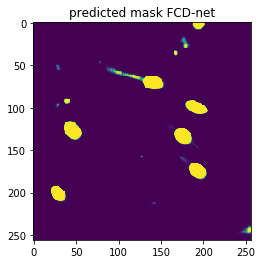

--------------------------------------------------


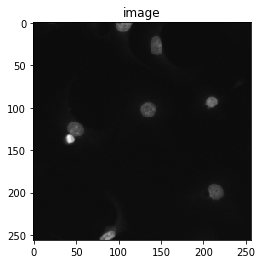

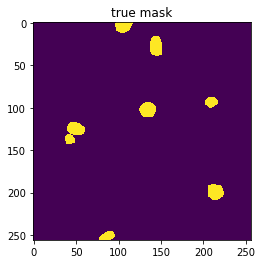

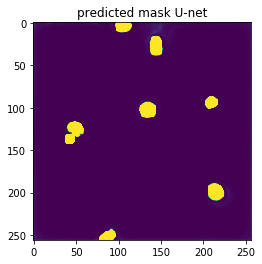

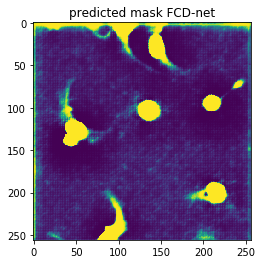

--------------------------------------------------


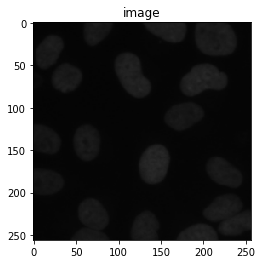

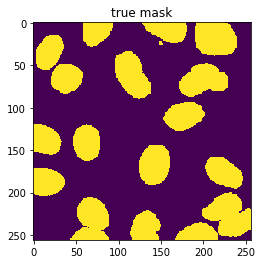

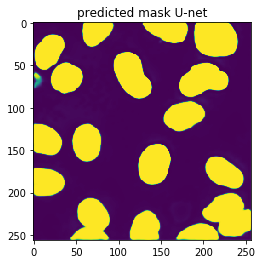

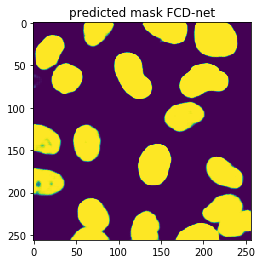

--------------------------------------------------


In [22]:
for image, true_mask, predicted_mask_unet, predicted_mask_fcdnet in zip(show_images_torch.cpu(), show_masks_torch.cpu(),
                                            predicted_masks_unet.detach().cpu(),
                                            predicted_masks_fcdnet.detach().cpu()):
  show(image, "image")
  show(true_mask, "true mask")
  show(predicted_mask_unet, "predicted mask U-net")
  show(predicted_mask_fcdnet, "predicted mask FCD-net")
  print("-"*50)


In [0]:
## Define prediction threshhold with 0.50:
bool_1 = predicted_masks_unet > 0.5
bool_2 = predicted_masks_fcdnet > 0.5 
predicted_masks_unet = bool_1.type(torch.FloatTensor)
predicted_masks_fcdnet = bool_2.type(torch.FloatTensor)

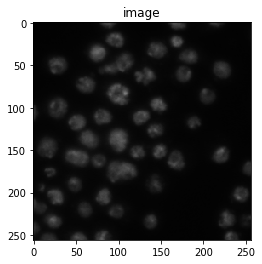

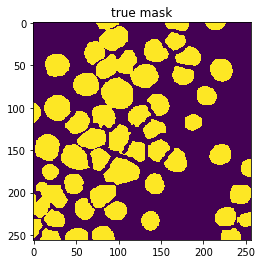

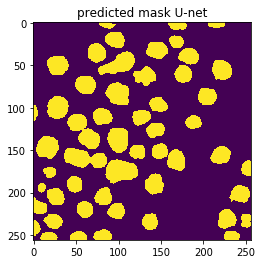

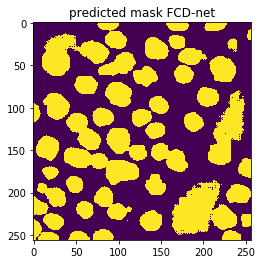

--------------------------------------------------


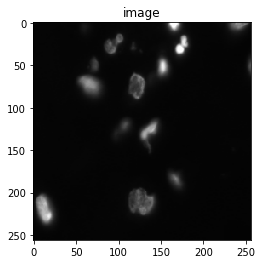

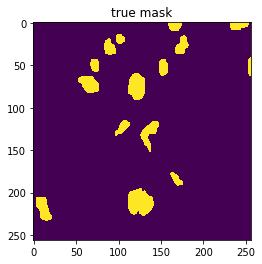

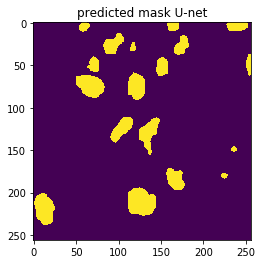

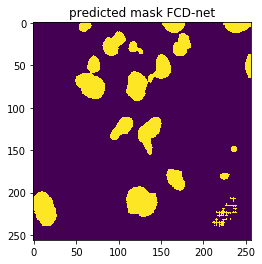

--------------------------------------------------


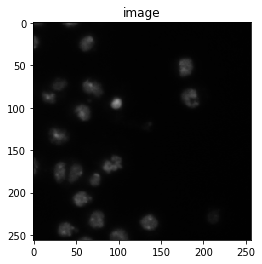

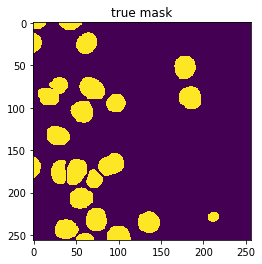

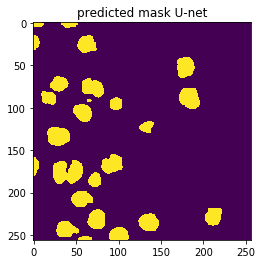

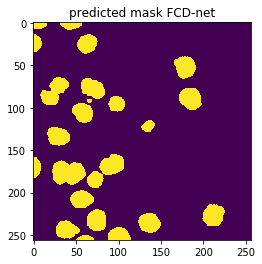

--------------------------------------------------


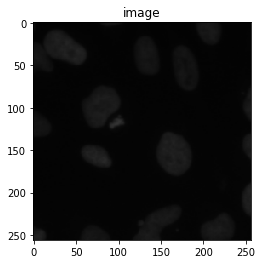

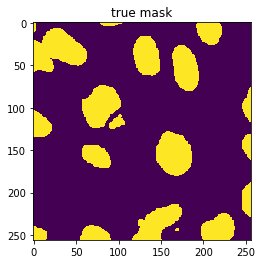

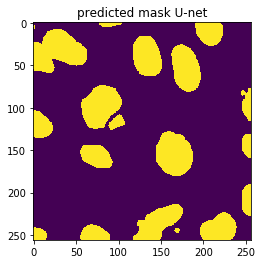

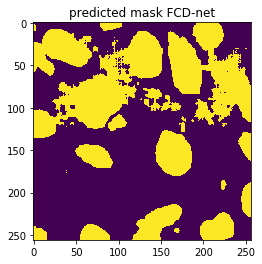

--------------------------------------------------


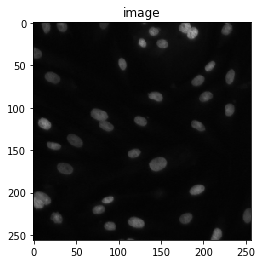

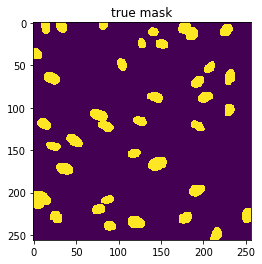

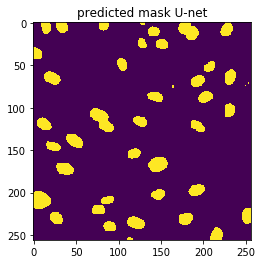

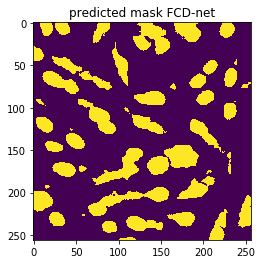

--------------------------------------------------


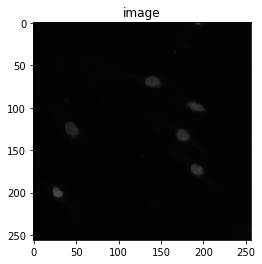

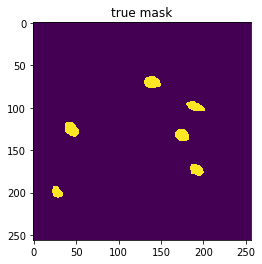

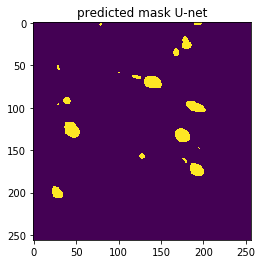

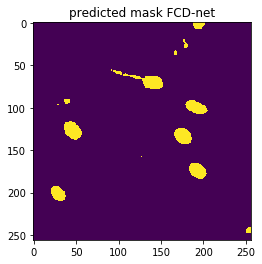

--------------------------------------------------


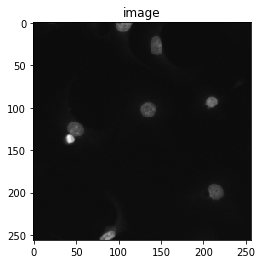

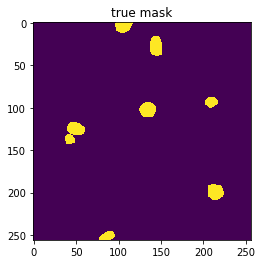

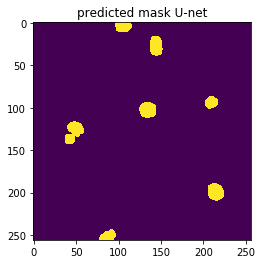

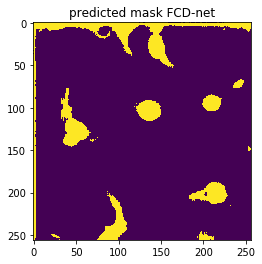

--------------------------------------------------


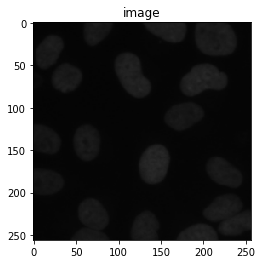

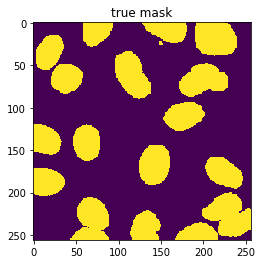

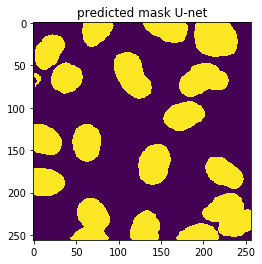

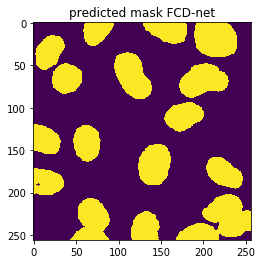

--------------------------------------------------


In [24]:
for image, true_mask, predicted_mask_unet, predicted_mask_fcdnet in zip(show_images_torch.cpu(), show_masks_torch.cpu(),
                                            predicted_masks_unet.detach().cpu(),
                                            predicted_masks_fcdnet.detach().cpu()):
  show(image, "image")
  show(true_mask, "true mask")
  show(predicted_mask_unet, "predicted mask U-net")
  show(predicted_mask_fcdnet, "predicted mask FCD-net")
  print("-"*50)

### Kaggle Submission


In [0]:
from skimage.morphology import label
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

In [0]:
test_path = 'data/stage1_test/'

In [0]:
test_ids = os.listdir(test_path)

In [10]:
import numpy as np
import sys
from tqdm import tqdm
# Get and resize test images
X_test = np.zeros((len(test_ids), 256, 256, 3), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = test_path + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:3]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (256, 256), mode='constant', preserve_range=True)
    X_test[n] = img

print('Done!')

Getting and resizing test images ... 


100%|██████████| 65/65 [00:19<00:00,  3.31it/s]

Done!


In [11]:
print(X_test.shape)

(65, 256, 256, 3)


In [0]:
test_tensor = torch.FloatTensor(X_test / 255)

In [0]:
test_tensor = test_tensor.permute(dims=(0, 3, 1, 2))

In [0]:
splits = np.split(np.arange(len(test_tensor)), 5)

In [0]:
import torch

In [0]:
def get_segmentation(model, x_tensor):
  y = ((torch.sigmoid(model(x_tensor))) > 0.5).type(torch.FloatTensor)
  return y

In [0]:
unet_model = unet_model.to(torch.device('cpu'))
fcdnet_model = fcdnet_model.to(torch.device('cpu'))
u_net_predicted_test = []
fcd_net_predicted_test = []

In [0]:
for indices in splits:
  u_net_predicted_test.append(get_segmentation(model=unet_model, x_tensor=test_tensor[indices]))

In [0]:
for indices in splits:
  fcd_net_predicted_test.append(get_segmentation(model=fcdnet_model, x_tensor=test_tensor[indices]))

In [0]:
u_net_predicted_test = torch.cat(u_net_predicted_test, dim=0)
fcd_net_predicted_test = torch.cat(fcd_net_predicted_test, dim=0)

In [26]:
print('Length: {}, {}'.format(len(u_net_predicted_test), len(fcd_net_predicted_test)))

Length: 65, 65


Visualize Segmentations for U-Net and FCD-Net

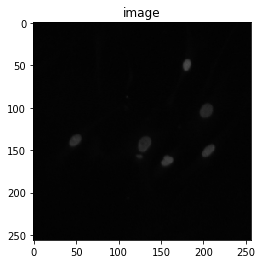

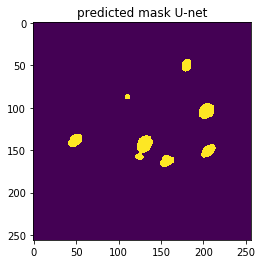

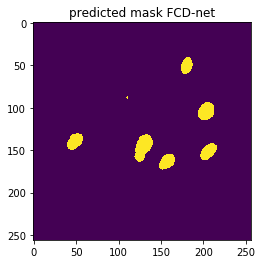

--------------------------------------------------


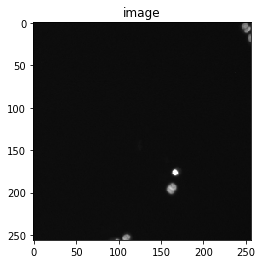

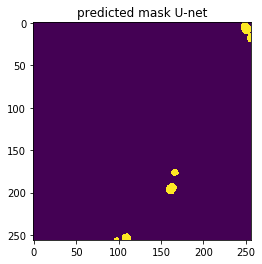

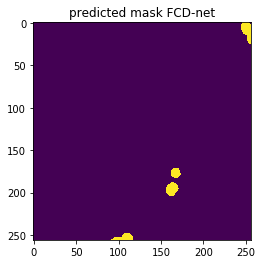

--------------------------------------------------


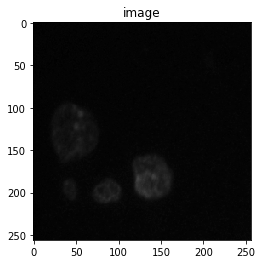

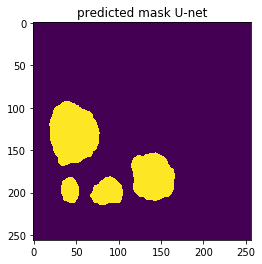

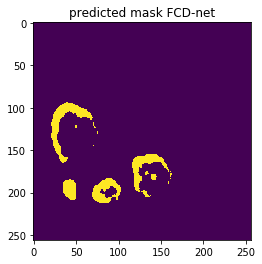

--------------------------------------------------


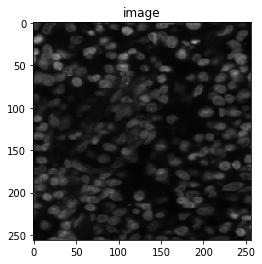

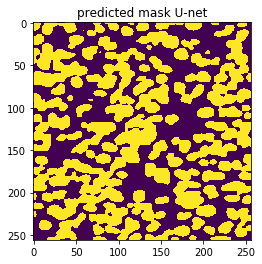

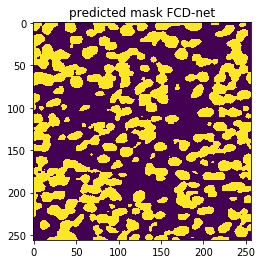

--------------------------------------------------


In [33]:
import matplotlib.pyplot as plt

for image, predicted_mask_unet, predicted_mask_fcdnet in zip(test_tensor[:4],
                                            u_net_predicted_test[:4],
                                            fcd_net_predicted_test[:4]):
  show(image, "image")
  show(predicted_mask_unet, "predicted mask U-net")
  show(predicted_mask_fcdnet, "predicted mask FCD-net")
  print("-"*50)

In [36]:
print(u_net_predicted_test.size())

torch.Size([65, 1, 256, 256])


In [0]:
## Submission for Kaggle using U-Net only because here it is the better model.
# swap axis for numpy and skimage processing
u_net_predicted_test = u_net_predicted_test.permute(dims=(0, 2, 3, 1))
u_net_predicted_test = u_net_predicted_test.numpy().astype(np.uint8)

In [0]:
# Create list of upsampled test masks
preds_test_upsampled = []
for i in range(len(u_net_predicted_test)):
    preds_test_upsampled.append(resize(np.squeeze(u_net_predicted_test[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))

In [0]:
# Run-length encoding taken from https://www.kaggle.com/rakhlin/fast-run-length-encoding-python
def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cutoff=0.5):
    lab_img = label(x > cutoff)
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)

In [0]:
new_test_ids = []
rles = []
for n, id_ in enumerate(test_ids):
    rle = list(prob_to_rles(preds_test_upsampled[n]))
    rles.extend(rle)
    new_test_ids.extend([id_] * len(rle))

In [0]:
import pandas as pd
# Create submission DataFrame
sub = pd.DataFrame()
sub['ImageId'] = new_test_ids
sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
sub.to_csv('u-net-predictions.csv', index=False)

In [43]:
sub.tail()

,ImageId,EncodedPixels
1989,d616d323a9eeb9da1b66f8d5df671d63c092c9919cb2c0...,71085 5 71603 8 72121 11 72639 12 73157 15 736...
1990,d616d323a9eeb9da1b66f8d5df671d63c092c9919cb2c0...,80424 3 80942 5 81463 3
1991,d616d323a9eeb9da1b66f8d5df671d63c092c9919cb2c0...,66930 4 67449 4
1992,d616d323a9eeb9da1b66f8d5df671d63c092c9919cb2c0...,80434 7 80953 10 81470 12 81987 14 82506 14 83...
1993,d616d323a9eeb9da1b66f8d5df671d63c092c9919cb2c0...,39437 4 39951 12 40469 14 40986 16 41505 16 42...


In [44]:
print('Finish.')

Finish.
